In [1]:
import numpy as np
import pandas as pd
import random
import sklearn

In [2]:
import sys
sys.path.append('..')


In [346]:
from feature_extract import *
from utils import load_data
from match_func import *
from models.lgb_model import lgb_model_for_upload,lgb_model_for_offline_test

In [347]:
import os
path0=os.path.abspath(os.path.dirname(os.getcwd()))
path = path0 +'/data/info_dataset/'
path1 = path0+'/data/'

In [348]:
# get feature

In [349]:
person =person_feature(path)
intent_table = person_intent(path)
work_history, work_history_table = work_history(path)
cert_table = certificate(path)
project_history, project_history_table = project_history(path)
job_table = job_table(path)

In [98]:
# load data
train_data, valid_data, test_data =load_data(path1)
del train_data['Unnamed: 0']
del valid_data['Unnamed: 0']
del test_data['Unnamed: 0']

In [220]:
data_all = pd.concat([train_data,valid_data,test_data], ignore_index=True)
candidate_data, job_data = diliver_current(data_all)

## offline

In [221]:
train=get_k_fold_data(train_data,person,intent_table,job_table,project_history_table,work_history_table,candidate_data,job_data)
valid_data0 =data_merge(valid_data,person,intent_table,job_table,project_history_table,work_history_table,candidate_data,job_data)
valid = get_data(valid_data0, train)
test_data0 =data_merge(test_data,person,intent_table,job_table,project_history_table,work_history_table,candidate_data,job_data)
test= get_data(test_data0, train)

In [222]:
train.shape,valid.shape,test.shape

((28232, 57), (7059, 57), (70774, 57))

In [223]:
temp_data= pd.concat([train,valid, test], ignore_index=True)

In [224]:
def deliver_record_feature(data_feature):
    for f1, f2 in tqdm([["岗位编号", "求职意向岗位类别"], ["岗位编号", "应聘者专业"], ["岗位编号", "求职意向工作地点"]]):
        data_feature[f"{f1}_{f2}_nunique"] = data_feature.groupby(
            [f1])[f2].transform("nunique")
    # 最大值、最小值、均值、标准差、众数、众数占比
    for f1, f2 in tqdm([["岗位编号", "年龄"], ["岗位编号", "工作年限"], ["岗位编号", "工作经历数"], ["岗位编号", "项目经验数"], ["岗位编号", "总主要业绩字数"],
                        ["岗位编号", "最高学历"], ["岗位编号", "可到职天数"]]):
        df_temp1 = data_feature.groupby(f1)[f2].agg(
            [(f"{f1}_{f2}_mean", "mean"),
             (f"{f1}_{f2}_max", "max"),
             (f"{f1}_{f2}_min", "min"),
             (f"{f1}_{f2}_std", "std"),
             (f"{f1}_{f2}_median", np.median),
             (f"{f1}_{f2}_mode", mode),
             (f"{f1}_{f2}_mode_rate", mode_rate)]
        ).reset_index()
        data_feature = data_feature.merge(df_temp1, how="left")

    # 男性占比、女性个数占比、工作地点符合否占比。
    for f1, f2 in [["岗位编号", "性别"], ["岗位编号", "工作地点符合否"]]:  # 性别众数及占比，工作地点符合及占比
        df_temp2 = data_feature.groupby(f1)[f2].agg(
            [
                (f"{f1}_{f2}_mode", mode),
                (f"{f1}_{f2}_mode_rate", mode_rate)]
        ).reset_index()
        data_feature = data_feature.merge(df_temp2, how="left")
    return data_feature

In [225]:
temp_data=deliver_record_feature(temp_data)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.32s/it]


In [20]:
pd.DataFrame(list(temp_data.columns)).to_csv(r'columns.csv')

In [14]:
train.shape,valid.shape,test.shape,temp_data.shape

((28232, 57), (7059, 57), (70774, 57), (106065, 113))

In [373]:
temp_data.head()

,岗位编号,求职者编号,标签,性别,工作年限,最高学历,应聘者专业,年龄,最近工作岗位,最近所在行业,...,岗位编号_可到职天数_max,岗位编号_可到职天数_min,岗位编号_可到职天数_std,岗位编号_可到职天数_median,岗位编号_可到职天数_mode,岗位编号_可到职天数_mode_rate,岗位编号_性别_mode,岗位编号_性别_mode_rate,岗位编号_工作地点符合否_mode,岗位编号_工作地点符合否_mode_rate
0,775040,5969825,0,1,12,3.0,None,34,品质/质检,NaN,...,180.0,7.0,19.058528,7.0,7.0,0.872093,1,0.738636,1.0,0.886364
1,799873,6139430,0,1,12,4.0,机电一体化,37,机械设计,零售百货行业,...,180.0,7.0,21.468561,7.0,7.0,0.754717,1,0.957944,1.0,0.957944
2,779698,6083324,0,1,0,1.0,特殊教育学,31,仓储管理,NaN,...,180.0,7.0,12.886417,7.0,7.0,0.935043,1,0.856661,0.0,0.984823
3,771109,5873085,0,0,6,4.0,财务管理,33,NaN,NaN,...,180.0,7.0,11.683337,7.0,7.0,0.892593,0,0.912088,0.0,0.948718
4,823833,6218282,0,0,0,3.0,英语,29,客户服务,NaN,...,180.0,7.0,14.694844,7.0,7.0,0.903654,0,0.891089,0.0,0.980198


## 添加求职者-岗位的匹配信息

In [190]:
data_all

,岗位编号,求职者编号,标签
0,775040,5969825,0
1,815337,6212884,0
2,770107,5451198,0
3,43795661,320873919,1
4,798922,5650936,0
...,...,...,...
106060,44350657,321173912,0
106061,44350657,321377962,0
106062,47578782,319583916,0
106063,47649893,6079047,0


In [111]:
data_all.head()
data_all.shape

(106065, 3)

In [112]:
data_all_tmp = data_all.merge(intent_table, on="求职者编号", how="left")
data_all_tmp = data_all_tmp.merge(job_data, on="岗位编号", how="left")

In [113]:
data_all_tmp = data_all_tmp.merge(person, on="求职者编号", how="left")
data_all_tmp = data_all_tmp.merge(job_table, on="岗位编号", how="left")

In [114]:
for func in ["simhash", "sim_jaccard", "difflibs"]:
        for ud in ["应聘者专业", "最近工作岗位", "最近所在行业", "专业特长",
                   "求职意向岗位类别", "求职意向所在行业", "自荐信"]:
            for jd in ["招聘职位", "对应聘者的专业要求", "具体要求"]:
                st = t.time()
                data_all_tmp[f"{ud}_{jd}_{func}"] = data_all_tmp.apply(lambda x: eval(func)(x[ud], x[jd]), axis=1)
                print(f"{ud}_{jd}_{func}，共耗时:", t.time() - st)

应聘者专业_招聘职位_simhash，共耗时: 42.26428723335266
应聘者专业_对应聘者的专业要求_simhash，共耗时: 51.95408082008362
应聘者专业_具体要求_simhash，共耗时: 89.82261204719543
最近工作岗位_招聘职位_simhash，共耗时: 46.14970636367798
最近工作岗位_对应聘者的专业要求_simhash，共耗时: 42.82719445228577
最近工作岗位_具体要求_simhash，共耗时: 87.93634223937988
最近所在行业_招聘职位_simhash，共耗时: 43.30438733100891
最近所在行业_对应聘者的专业要求_simhash，共耗时: 47.43039274215698
最近所在行业_具体要求_simhash，共耗时: 84.6497802734375
专业特长_招聘职位_simhash，共耗时: 83.13723707199097
专业特长_对应聘者的专业要求_simhash，共耗时: 72.54772758483887
专业特长_具体要求_simhash，共耗时: 106.45567846298218
求职意向岗位类别_招聘职位_simhash，共耗时: 44.421353578567505
求职意向岗位类别_对应聘者的专业要求_simhash，共耗时: 44.61356472969055
求职意向岗位类别_具体要求_simhash，共耗时: 78.405437707901
求职意向所在行业_招聘职位_simhash，共耗时: 42.73877763748169
求职意向所在行业_对应聘者的专业要求_simhash，共耗时: 45.361088514328
求职意向所在行业_具体要求_simhash，共耗时: 79.20682501792908
自荐信_招聘职位_simhash，共耗时: 81.16894745826721
自荐信_对应聘者的专业要求_simhash，共耗时: 84.36542558670044
自荐信_具体要求_simhash，共耗时: 114.31796526908875
应聘者专业_招聘职位_sim_jaccard，共耗时: 21.263596057891846
应聘者专业_对应聘者的专业要求_sim_jac

In [429]:
data_all_tmp[data_all_tmp.columns[-64:]].drop_duplicates().求职者编号_岗位编号.value_counts()

3513200802838        1
490915343668705      1
5826377775090        1
32064790043795661    1
5990345762697        1
                    ..
5393746805640        1
6031185770860        1
6232067773644        1
32144191843892657    1
5981094782877        1
Name: 求职者编号_岗位编号, Length: 106065, dtype: int64

In [116]:
data_all_tmp.head()

,岗位编号,求职者编号,标签,自荐信,求职意向岗位类别,求职意向工作地点,求职意向所在行业,可到职天数,其他说明,自荐信字数,...,专业特长_具体要求_difflibs,求职意向岗位类别_招聘职位_difflibs,求职意向岗位类别_对应聘者的专业要求_difflibs,求职意向岗位类别_具体要求_difflibs,求职意向所在行业_招聘职位_difflibs,求职意向所在行业_对应聘者的专业要求_difflibs,求职意向所在行业_具体要求_difflibs,自荐信_招聘职位_difflibs,自荐信_对应聘者的专业要求_difflibs,自荐信_具体要求_difflibs
0,775040,5969825,0,一直以来，以以身作则，不断进取的心态去面对工作和生活，在带给别人快乐和收获的同时，也陶冶，充...,品质质检,深圳市,其它,7.0,品质工程师,50.0,...,0.18543,0.000000,0.000000,0.120000,0.0,0.0,0.000000,0.000000,0.000000,0.104167
1,815337,6212884,0,"为人诚实谦虚,工作踏实认真,有独立工作能力以团队协作的能力,良好的沟通协调能力.已婚,有小孩...",出纳,深圳市,其它,7.0,NaN,56.0,...,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.260163
2,770107,5451198,0,诚实可靠 能吃苦 做事尽职尽责,电子技术,深圳市,电子行业,7.0,NaN,16.0,...,0.00000,0.444444,0.500000,0.148148,0.0,0.5,0.148148,0.000000,0.000000,0.000000
3,43795661,320873919,1,本人工作认真，即使极细小的工作也会亲自去做好；性格开朗，待人诚恳，具有良好的涉交能力；专业技...,国际贸易涉外业务,深圳市,商业零售行业,7.0,NaN,116.0,...,0.02963,0.333333,0.000000,0.088235,0.0,0.0,0.029851,0.000000,0.000000,0.213115
4,798922,5650936,0,具有较强责任心，人际关系良好，能吃苦耐劳；曾担任校生活部干事，负责部门宣传工作和文案策划；有...,行政人力资源管理文职类,深圳市,NaN,30.0,NaN,89.0,...,0.02240,0.153846,0.235294,0.000000,0.0,0.0,0.000000,0.021978,0.042105,0.058824


In [117]:
data_all_tmp["求职者编号_岗位编号"]=data_all_tmp["求职者编号"].astype("str")+data_all_tmp["岗位编号"].astype("str")

In [118]:
data_all_tmp[data_all_tmp.求职者编号_岗位编号=="5873085771109"]["求职意向岗位类别_对应聘者的专业要求_simhash"]

15    0.484848
Name: 求职意向岗位类别_对应聘者的专业要求_simhash, dtype: float64

In [226]:
temp_data["求职者编号_岗位编号"]=temp_data["求职者编号"].astype("str")+temp_data["岗位编号"].astype("str")

In [227]:
temp_data.head(1)

,岗位编号,求职者编号,标签,性别,工作年限,最高学历,应聘者专业,年龄,最近工作岗位,最近所在行业,...,岗位编号_可到职天数_min,岗位编号_可到职天数_std,岗位编号_可到职天数_median,岗位编号_可到职天数_mode,岗位编号_可到职天数_mode_rate,岗位编号_性别_mode,岗位编号_性别_mode_rate,岗位编号_工作地点符合否_mode,岗位编号_工作地点符合否_mode_rate,求职者编号_岗位编号
0,775040,5969825,0,1,12,3.0,None,34,品质/质检,NaN,...,7.0,19.058528,7.0,7.0,0.872093,1,0.738636,1.0,0.886364,5969825775040


In [228]:
temp_data = temp_data[["岗位编号", "求职者编号", "标签","求职者编号_岗位编号"] + [column for column in temp_data.columns if
                                                   column not in ["岗位编号", "求职者编号", "标签","求职者编号_岗位编号"]]]

In [122]:
temp_data.shape

(106065, 114)

In [176]:
for col in data_all_tmp.columns[-64:]:
    data_all_tmp[col]=pd.cut(data_all_tmp[col], bins=np.arange(0,1,0.1))


TypeError: '<' not supported between instances of 'float' and 'str'

In [242]:
def to_string(x):
    if x:
        return str(x)
    else:
        return None

In [246]:
for col in temp_data.columns[-64:]:
    data_all_tmp[col] = data_all_tmp[col].apply(lambda x:to_string(x)).astype("category")

In [275]:
data_all_tmp

,岗位编号,求职者编号,标签,自荐信,求职意向岗位类别,求职意向工作地点,求职意向所在行业,可到职天数,其他说明,自荐信字数,...,求职意向岗位类别_招聘职位_difflibs,求职意向岗位类别_对应聘者的专业要求_difflibs,求职意向岗位类别_具体要求_difflibs,求职意向所在行业_招聘职位_difflibs,求职意向所在行业_对应聘者的专业要求_difflibs,求职意向所在行业_具体要求_difflibs,自荐信_招聘职位_difflibs,自荐信_对应聘者的专业要求_difflibs,自荐信_具体要求_difflibs,求职者编号_岗位编号
0,775040,5969825,0,一直以来，以以身作则，不断进取的心态去面对工作和生活，在带给别人快乐和收获的同时，也陶冶，充...,品质质检,深圳市,其它,7.0,品质工程师,50.0,...,9,8,1,8,6,4,6,5,1,5969825775040
1,815337,6212884,0,"为人诚实谦虚,工作踏实认真,有独立工作能力以团队协作的能力,良好的沟通协调能力.已婚,有小孩...",出纳,深圳市,其它,7.0,NaN,56.0,...,1,1,0,8,6,4,0,0,2,6212884815337
2,770107,5451198,0,诚实可靠 能吃苦 做事尽职尽责,电子技术,深圳市,电子行业,7.0,NaN,16.0,...,2,1,0,8,6,4,6,5,1,5451198770107
3,43795661,320873919,1,本人工作认真，即使极细小的工作也会亲自去做好；性格开朗，待人诚恳，具有良好的涉交能力；专业技...,国际贸易涉外业务,深圳市,商业零售行业,7.0,NaN,116.0,...,4,8,0,8,6,4,0,5,4,32087391943795661
4,798922,5650936,0,具有较强责任心，人际关系良好，能吃苦耐劳；曾担任校生活部干事，负责部门宣传工作和文案策划；有...,行政人力资源管理文职类,深圳市,NaN,30.0,NaN,89.0,...,9,8,7,8,6,0,6,5,7,5650936798922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106060,44350657,321173912,0,1、性格开朗，交际能力强，有较强的责任感、沟通能力和团队意识2、热爱编程，自学能力强；系统学...,软件开发,深圳市,信息行业（IT/通讯/互联网）,7.0,NaN,109.0,...,2,8,0,8,6,4,0,5,1,32117391244350657
106061,44350657,321377962,0,是一个活泼开朗、乐观向上、兴趣广泛、乐于助人、勤奋好学、脚踏实地、认真负责、吃苦...,单片机DSLDSP底层开发,深圳市,电子行业,7.0,NaN,152.0,...,1,8,0,8,6,4,0,5,1,32137796244350657
106062,47578782,319583916,0,"是一个性格开朗热爱交际的女生，有较强的自学能力和动手能力,良好的协调沟通能力，适应力强,责任...",电子通讯类,深圳市,NaN,7.0,NaN,141.0,...,9,8,7,8,6,4,6,5,1,31958391647578782
106063,47649893,6079047,0,1：本人成熟稳重，能力强，心态稳定，能担当重任； 2：营销与管理经验丰富，接受能力强，能迅速...,公关营销业务类,深圳市,NaN,7.0,NaN,153.0,...,9,8,0,8,6,4,6,5,2,607904747649893


In [244]:
temp_data[temp_data.columns[-64:]].drop_duplicates()

,岗位编号_工作地点符合否_mode_rate,应聘者专业_招聘职位_simhash,应聘者专业_对应聘者的专业要求_simhash,应聘者专业_具体要求_simhash,最近工作岗位_招聘职位_simhash,最近工作岗位_对应聘者的专业要求_simhash,最近工作岗位_具体要求_simhash,最近所在行业_招聘职位_simhash,最近所在行业_对应聘者的专业要求_simhash,最近所在行业_具体要求_simhash,...,专业特长_具体要求_difflibs,求职意向岗位类别_招聘职位_difflibs,求职意向岗位类别_对应聘者的专业要求_difflibs,求职意向岗位类别_具体要求_difflibs,求职意向所在行业_招聘职位_difflibs,求职意向所在行业_对应聘者的专业要求_difflibs,求职意向所在行业_具体要求_difflibs,自荐信_招聘职位_difflibs,自荐信_对应聘者的专业要求_difflibs,自荐信_具体要求_difflibs
0,0.886364,"(0.5, 0.6]",NaN,"(0.4, 0.5]","(0.5, 0.6]","(0.5, 0.6]","(0.5, 0.6]","(0.5, 0.6]",NaN,"(0.4, 0.5]",...,"(0.1, 0.2]",NaN,NaN,"(0.1, 0.2]",NaN,NaN,NaN,NaN,NaN,"(0.1, 0.2]"
1,0.957944,"(0.6, 0.7]","(0.6, 0.7]","(0.4, 0.5]","(0.7, 0.8]","(0.8, 0.9]","(0.6, 0.7]","(0.4, 0.5]","(0.3, 0.4]","(0.4, 0.5]",...,"(0.0, 0.1]","(0.1, 0.2]","(0.1, 0.2]","(0.0, 0.1]",NaN,NaN,NaN,"(0.0, 0.1]","(0.0, 0.1]","(0.2, 0.3]"
2,0.984823,"(0.4, 0.5]","(0.4, 0.5]","(0.4, 0.5]","(0.4, 0.5]","(0.5, 0.6]","(0.4, 0.5]","(0.4, 0.5]","(0.4, 0.5]","(0.4, 0.5]",...,NaN,"(0.2, 0.3]","(0.1, 0.2]","(0.0, 0.1]",NaN,NaN,NaN,NaN,NaN,"(0.1, 0.2]"
3,0.948718,"(0.5, 0.6]","(0.4, 0.5]","(0.5, 0.6]","(0.5, 0.6]","(0.4, 0.5]","(0.5, 0.6]","(0.5, 0.6]","(0.4, 0.5]","(0.5, 0.6]",...,NaN,"(0.4, 0.5]",NaN,"(0.0, 0.1]",NaN,NaN,NaN,"(0.0, 0.1]",NaN,"(0.4, 0.5]"
4,0.980198,"(0.4, 0.5]","(0.5, 0.6]","(0.5, 0.6]","(0.5, 0.6]","(0.4, 0.5]","(0.4, 0.5]","(0.5, 0.6]",NaN,"(0.5, 0.6]",...,"(0.1, 0.2]",NaN,NaN,NaN,NaN,NaN,"(0.0, 0.1]",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106060,1.000000,"(0.4, 0.5]","(0.4, 0.5]","(0.5, 0.6]","(0.5, 0.6]","(0.5, 0.6]","(0.4, 0.5]","(0.6, 0.7]","(0.5, 0.6]","(0.4, 0.5]",...,"(0.3, 0.4]","(0.2, 0.3]",NaN,"(0.0, 0.1]",NaN,NaN,NaN,"(0.0, 0.1]",NaN,"(0.1, 0.2]"
106061,1.000000,"(0.4, 0.5]","(0.5, 0.6]","(0.5, 0.6]","(0.5, 0.6]",NaN,"(0.5, 0.6]","(0.5, 0.6]",NaN,"(0.5, 0.6]",...,"(0.3, 0.4]","(0.1, 0.2]",NaN,"(0.0, 0.1]",NaN,NaN,NaN,"(0.0, 0.1]",NaN,"(0.1, 0.2]"
106062,1.000000,"(0.4, 0.5]","(0.5, 0.6]","(0.5, 0.6]","(0.4, 0.5]",NaN,"(0.4, 0.5]","(0.4, 0.5]",NaN,"(0.4, 0.5]",...,"(0.1, 0.2]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(0.1, 0.2]"
106063,1.000000,"(0.5, 0.6]",NaN,"(0.4, 0.5]","(0.4, 0.5]","(0.4, 0.5]","(0.4, 0.5]","(0.5, 0.6]","(0.4, 0.5]","(0.5, 0.6]",...,"(0.2, 0.3]",NaN,NaN,"(0.0, 0.1]",NaN,NaN,NaN,NaN,NaN,"(0.2, 0.3]"


In [247]:
temp_data.head()

,岗位编号,求职者编号,标签,求职者编号_岗位编号,性别,工作年限,最高学历,应聘者专业,年龄,最近工作岗位,...,专业特长_具体要求_difflibs,求职意向岗位类别_招聘职位_difflibs,求职意向岗位类别_对应聘者的专业要求_difflibs,求职意向岗位类别_具体要求_difflibs,求职意向所在行业_招聘职位_difflibs,求职意向所在行业_对应聘者的专业要求_difflibs,求职意向所在行业_具体要求_difflibs,自荐信_招聘职位_difflibs,自荐信_对应聘者的专业要求_difflibs,自荐信_具体要求_difflibs
0,775040,5969825,0,43073,1,12,3.0,0,34,281,...,"(0.1, 0.2]",NaN,NaN,"(0.1, 0.2]",NaN,NaN,NaN,NaN,NaN,"(0.1, 0.2]"
1,799873,6139430,0,75369,1,12,4.0,216,37,86,...,"(0.0, 0.1]","(0.1, 0.2]","(0.1, 0.2]","(0.0, 0.1]",NaN,NaN,NaN,"(0.0, 0.1]","(0.0, 0.1]","(0.2, 0.3]"
2,779698,6083324,0,64742,1,0,1.0,276,31,235,...,NaN,"(0.2, 0.3]","(0.1, 0.2]","(0.0, 0.1]",NaN,NaN,NaN,NaN,NaN,"(0.1, 0.2]"
3,771109,5873085,0,37815,0,6,4.0,373,33,226,...,NaN,"(0.4, 0.5]",NaN,"(0.0, 0.1]",NaN,NaN,NaN,"(0.0, 0.1]",NaN,"(0.4, 0.5]"
4,823833,6218282,0,88752,0,0,3.0,349,29,12,...,"(0.1, 0.2]",NaN,NaN,NaN,NaN,NaN,"(0.0, 0.1]",NaN,NaN,NaN


In [229]:
temp_data = pd.merge(temp_data,data_all_tmp[data_all_tmp.columns[-64:]].drop_duplicates(),on='求职者编号_岗位编号')

In [351]:
temp_data.head()

,岗位编号,求职者编号,标签,求职者编号_岗位编号,性别,工作年限,最高学历,应聘者专业,年龄,最近工作岗位,...,专业特长_具体要求_difflibs,求职意向岗位类别_招聘职位_difflibs,求职意向岗位类别_对应聘者的专业要求_difflibs,求职意向岗位类别_具体要求_difflibs,求职意向所在行业_招聘职位_difflibs,求职意向所在行业_对应聘者的专业要求_difflibs,求职意向所在行业_具体要求_difflibs,自荐信_招聘职位_difflibs,自荐信_对应聘者的专业要求_difflibs,自荐信_具体要求_difflibs
0,775040,5969825,0,43073,1,12,3.0,0,34,21,...,1,9,8,1,8,6,4,6,5,1
1,799873,6139430,0,75369,1,12,4.0,216,37,119,...,0,1,1,0,8,6,4,0,0,2
2,779698,6083324,0,64742,1,0,1.0,276,31,255,...,7,2,1,0,8,6,4,6,5,1
3,771109,5873085,0,37815,0,6,4.0,373,33,242,...,7,4,8,0,8,6,4,0,5,4
4,823833,6218282,0,88752,0,0,3.0,349,29,65,...,1,9,8,7,8,6,0,6,5,7


In [443]:
train.head().to_csv(r'result.csv')

In [381]:
data_all_feature.head(1)

,岗位编号,求职者编号,标签,求职者编号_岗位编号,性别,工作年限,最高学历,应聘者专业,年龄,最近工作岗位,...,专业特长_具体要求_difflibs,求职意向岗位类别_招聘职位_difflibs,求职意向岗位类别_对应聘者的专业要求_difflibs,求职意向岗位类别_具体要求_difflibs,求职意向所在行业_招聘职位_difflibs,求职意向所在行业_对应聘者的专业要求_difflibs,求职意向所在行业_具体要求_difflibs,自荐信_招聘职位_difflibs,自荐信_对应聘者的专业要求_difflibs,自荐信_具体要求_difflibs
0,775040,5969825,0,5969825775040,1,12,3.0,None,34,品质/质检,...,0.18543,0.0,0.0,0.12,0.0,0.0,0.0,0.0,0.0,0.104167


## 添加求职者历史信息

In [354]:
data_all_tmp_hist = data_all_tmp.merge(work_history, on="求职者编号", how="left")
data_all_tmp_hist = data_all_tmp_hist.merge(project_history, on="求职者编号", how="left")

In [353]:
data_all_tmp.head()

,岗位编号,求职者编号,标签,自荐信,求职意向岗位类别,求职意向工作地点,求职意向所在行业,可到职天数,其他说明,自荐信字数,...,求职意向岗位类别_招聘职位_difflibs,求职意向岗位类别_对应聘者的专业要求_difflibs,求职意向岗位类别_具体要求_difflibs,求职意向所在行业_招聘职位_difflibs,求职意向所在行业_对应聘者的专业要求_difflibs,求职意向所在行业_具体要求_difflibs,自荐信_招聘职位_difflibs,自荐信_对应聘者的专业要求_difflibs,自荐信_具体要求_difflibs,求职者编号_岗位编号
0,775040,5969825,0,一直以来，以以身作则，不断进取的心态去面对工作和生活，在带给别人快乐和收获的同时，也陶冶，充...,品质质检,深圳市,其它,7.0,品质工程师,50.0,...,9,8,1,8,6,4,6,5,1,5969825775040
1,815337,6212884,0,"为人诚实谦虚,工作踏实认真,有独立工作能力以团队协作的能力,良好的沟通协调能力.已婚,有小孩...",出纳,深圳市,其它,7.0,NaN,56.0,...,1,1,0,8,6,4,0,0,2,6212884815337
2,770107,5451198,0,诚实可靠 能吃苦 做事尽职尽责,电子技术,深圳市,电子行业,7.0,NaN,16.0,...,2,1,0,8,6,4,6,5,1,5451198770107
3,43795661,320873919,1,本人工作认真，即使极细小的工作也会亲自去做好；性格开朗，待人诚恳，具有良好的涉交能力；专业技...,国际贸易涉外业务,深圳市,商业零售行业,7.0,NaN,116.0,...,4,8,0,8,6,4,0,5,4,32087391943795661
4,798922,5650936,0,具有较强责任心，人际关系良好，能吃苦耐劳；曾担任校生活部干事，负责部门宣传工作和文案策划；有...,行政人力资源管理文职类,深圳市,NaN,30.0,NaN,89.0,...,9,8,7,8,6,0,6,5,7,5650936798922


In [355]:
    
for func in ["simhash", "sim_jaccard", "difflibs"]:
    for wh in ["工作经历岗位类别", "工作经历单位所属行业", "工作经历主要业绩"]:
        for jd in ["招聘职位", "对应聘者的专业要求", "具体要求"]:
            st = t.time()
            data_all_tmp_hist[f"{wh}_{jd}_{func}"] = data_all_tmp_hist.apply(lambda x: eval(func)(x[wh], x[jd]),
                                                             axis=1)
            df_temp1 = data_all_tmp_hist.groupby("求职者编号_岗位编号")[f"{wh}_{jd}_{func}"].agg(
                [(f"{wh}_{jd}_{func}_mean", "mean"),
                 (f"{wh}_{jd}_{func}_max", "max"),
                 (f"{wh}_{jd}_{func}_min", "min"),
                 (f"{wh}_{jd}_{func}_std", "std")]
            ).reset_index()
            data_all_tmp = data_all_tmp.merge(df_temp1, on="求职者编号_岗位编号", how="left")
            print(f"{wh}_{jd}_{func}，共耗时:", t.time() - st)
"""project history column:["项目名称", "项目说明", "职责说明", "关键技术"]"""
for func in ["simhash", "sim_jaccard", "difflibs"]:
    for ph in ["项目名称", "项目说明", "职责说明", "关键技术"]:
        for jd in ["招聘职位", "对应聘者的专业要求", "具体要求"]:
            st = t.time()
            data_all_tmp_hist[f"{ph}_{jd}_{func}"] = data_all_tmp_hist.apply(lambda x: eval(func)(x[ph], x[jd]),
                                                               axis=1)
            df_temp2 = data_all_tmp_hist.groupby("求职者编号_岗位编号")[f"{ph}_{jd}_{func}"].agg(
                [(f"{ph}_{jd}_{func}_mean", "mean"),
                 (f"{ph}_{jd}_{func}_max", "max"),
                 (f"{ph}_{jd}_{func}_min", "min"),
                 (f"{ph}_{jd}_{func}_std", "std")]
            ).reset_index()
            data_all_tmp = data_all_tmp.merge(df_temp2, on="求职者编号_岗位编号", how="left")
            print(f"{ph}_{jd}_{func}，共耗时:", t.time() - st)

工作经历岗位类别_招聘职位_simhash，共耗时: 129.57405805587769
工作经历岗位类别_对应聘者的专业要求_simhash，共耗时: 132.03116154670715
工作经历岗位类别_具体要求_simhash，共耗时: 245.30179619789124
工作经历单位所属行业_招聘职位_simhash，共耗时: 146.30499458312988
工作经历单位所属行业_对应聘者的专业要求_simhash，共耗时: 135.62731313705444
工作经历单位所属行业_具体要求_simhash，共耗时: 226.98690342903137
工作经历主要业绩_招聘职位_simhash，共耗时: 231.73244094848633


KeyboardInterrupt: 

In [ ]:
data_all_tmp

# 岗位名称是否在工作经历中和项目经历中出现

In [338]:
work_history = work_history.groupby('求职者编号')['工作经历主要业绩'].apply(lambda x:x.str.cat(sep=':')).reset_index()

In [340]:
project_history["项目说明_职责说明"] =project_history.项目说明+project_history.职责说明
project_history = project_history.groupby('求职者编号')['项目说明_职责说明'].apply(lambda x:x.str.cat(sep=':')).reset_index()

In [341]:
project_history.head()

,求职者编号,项目说明_职责说明
0,20640,获抽油烟机专利一项。设计新型抽油烟机，申请专利，专利说明书撰写等。
1,23286,根据客户要求设计开发****手机，提供主板设计方案。对项目的整个品质进行控制，新物料的导入，...
2,24295,该****公司供应链、物料控制、财务核算和成本控制等多方面的系统方案。负责项目实施
3,41780,●通过与美国军标委员会的美籍华人合作，成功开发了激光发生器重要零件的表面处理防护****公司...
4,42480,为电动汽车提供交流电源设备:电气参数:1.输入电压：AC****-****V 2.输出电压：...


In [342]:
def job_name_work_history_match(name, txt):
    """
    :todo:
    :param name:岗位名称
    :param txt:业绩描述
    :return:
    """
    txt = txt.split(name)
    if len(txt) == 1:
        return 0
    else:
        return len(txt) - 1


In [344]:
pd.merge(train_data,job_table,on='岗位编号')

,岗位编号,求职者编号,标签,招聘对象代码,招聘对象,招聘职位,对应聘者的专业要求,岗位最低学历,岗位工作地点,岗位工作年限,具体要求,具体要求字数,是否有专业限制
0,775040,5969825,0,2.0,社会无职,IPQC/组长,NaN,2.0,深圳市,0,熟悉电脑办公软件运用及多项品质管理手法，认识或了解变压器制程及工艺要求，具有强烈的品质观念。,46.0,False
1,775040,6061410,0,2.0,社会无职,IPQC/组长,NaN,2.0,深圳市,0,熟悉电脑办公软件运用及多项品质管理手法，认识或了解变压器制程及工艺要求，具有强烈的品质观念。,46.0,False
2,775040,6050609,0,2.0,社会无职,IPQC/组长,NaN,2.0,深圳市,0,熟悉电脑办公软件运用及多项品质管理手法，认识或了解变压器制程及工艺要求，具有强烈的品质观念。,46.0,False
3,775040,5955550,0,2.0,社会无职,IPQC/组长,NaN,2.0,深圳市,0,熟悉电脑办公软件运用及多项品质管理手法，认识或了解变压器制程及工艺要求，具有强烈的品质观念。,46.0,False
4,775040,6057948,0,2.0,社会无职,IPQC/组长,NaN,2.0,深圳市,0,熟悉电脑办公软件运用及多项品质管理手法，认识或了解变压器制程及工艺要求，具有强烈的品质观念。,46.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28227,810497,5466072,0,-1.0,NaN,工程师,【计算机科学与技术】,2.0,福田区,0,计算机专业毕业，有无工作经验均可！！,18.0,True
28228,43219673,318407913,1,2.0,社会无职,电子硬件工程师,电子信息工程学,1.0,深圳市,0,中专以上学历，一年以上工作经验，熟练运用Protel软件，熟悉电子元器件与电子电路，积极上进...,75.0,True
28229,42976662,317003043,1,1.0,社会在职,IT 外包业务员,NaN,NaN,深圳市,5,大专以上学历，从事电脑维护销售工作三年以上，有一定的客户基础。,31.0,False
28230,44285651,5215489,1,1.0,社会在职,电气工程师,NaN,NaN,深圳市,5,NaN,NaN,False


## 划分数据集

In [261]:
from sklearn.preprocessing import LabelEncoder
# # 分箱
# for col in temp_data.columns[-63:]:
#     temp_data[col]=pd.cut(temp_data[col], bins=np.arange(0,1,0.1))
for f in temp_data.select_dtypes('object'):
    le = LabelEncoder()
    print(f)
    temp_data[f] = le.fit_transform(temp_data[f].astype('str'))
for col in temp_data.columns[-63:]:
    temp_data[col] = le.fit_transform(temp_data[col].astype('str'))
    print(col)
temp_data["招聘对象"] =le.fit_transform(temp_data["招聘对象"].astype('str'))
temp_data["最近工作岗位"] =le.fit_transform(temp_data["最近工作岗位"].astype('str'))
temp_data["求职意向岗位类别"] =le.fit_transform(temp_data["求职意向岗位类别"].astype('str'))
# none one-hot
data_all_feature=temp_data

应聘者专业_招聘职位_simhash
应聘者专业_对应聘者的专业要求_simhash
应聘者专业_具体要求_simhash
最近工作岗位_招聘职位_simhash
最近工作岗位_对应聘者的专业要求_simhash
最近工作岗位_具体要求_simhash
最近所在行业_招聘职位_simhash
最近所在行业_对应聘者的专业要求_simhash
最近所在行业_具体要求_simhash
专业特长_招聘职位_simhash
专业特长_对应聘者的专业要求_simhash
专业特长_具体要求_simhash
求职意向岗位类别_招聘职位_simhash
求职意向岗位类别_对应聘者的专业要求_simhash
求职意向岗位类别_具体要求_simhash
求职意向所在行业_招聘职位_simhash
求职意向所在行业_对应聘者的专业要求_simhash
求职意向所在行业_具体要求_simhash
自荐信_招聘职位_simhash
自荐信_对应聘者的专业要求_simhash
自荐信_具体要求_simhash
应聘者专业_招聘职位_sim_jaccard
应聘者专业_对应聘者的专业要求_sim_jaccard
应聘者专业_具体要求_sim_jaccard
最近工作岗位_招聘职位_sim_jaccard
最近工作岗位_对应聘者的专业要求_sim_jaccard
最近工作岗位_具体要求_sim_jaccard
最近所在行业_招聘职位_sim_jaccard
最近所在行业_对应聘者的专业要求_sim_jaccard
最近所在行业_具体要求_sim_jaccard
专业特长_招聘职位_sim_jaccard
专业特长_对应聘者的专业要求_sim_jaccard
专业特长_具体要求_sim_jaccard
求职意向岗位类别_招聘职位_sim_jaccard
求职意向岗位类别_对应聘者的专业要求_sim_jaccard
求职意向岗位类别_具体要求_sim_jaccard
求职意向所在行业_招聘职位_sim_jaccard
求职意向所在行业_对应聘者的专业要求_sim_jaccard
求职意向所在行业_具体要求_sim_jaccard
自荐信_招聘职位_sim_jaccard
自荐信_对应聘者的专业要求_sim_jaccard
自荐信_具体要求_sim_jaccard
应聘者专业_招聘职位_difflib

In [337]:
data_all_feature.to_csv(r'feature_offline_175.csv')

In [249]:
train_data.shape,valid.shape,train.shape

((28232, 3), (7059, 175), (28232, 175))

In [262]:
data_all_feature=temp_data
train0 = data_all_feature[:train_data.shape[0]]#.标签.value_counts()
valid0 = data_all_feature[train_data.shape[0]:train_data.shape[0]+valid_data.shape[0]]
train_label = train0[["标签"]]
valid_label = valid0[["标签"]]
train=train0[list(train0.columns)[:2]+list(train0.columns)[4:]]
valid=valid0[list(train0.columns)[:2]+list(train0.columns)[4:]]


In [263]:
train.head()

,岗位编号,求职者编号,性别,工作年限,最高学历,应聘者专业,年龄,最近工作岗位,最近所在行业,当前工作所在地,...,专业特长_具体要求_difflibs,求职意向岗位类别_招聘职位_difflibs,求职意向岗位类别_对应聘者的专业要求_difflibs,求职意向岗位类别_具体要求_difflibs,求职意向所在行业_招聘职位_difflibs,求职意向所在行业_对应聘者的专业要求_difflibs,求职意向所在行业_具体要求_difflibs,自荐信_招聘职位_difflibs,自荐信_对应聘者的专业要求_difflibs,自荐信_具体要求_difflibs
0,775040,5969825,1,12,3.0,0,34,21,0,43,...,1,9,8,1,8,6,4,6,5,1
1,799873,6139430,1,12,4.0,216,37,119,116,43,...,0,1,1,0,8,6,4,0,0,2
2,779698,6083324,1,0,1.0,276,31,255,0,43,...,7,2,1,0,8,6,4,6,5,1
3,771109,5873085,0,6,4.0,373,33,242,0,43,...,7,4,8,0,8,6,4,0,5,4
4,823833,6218282,0,0,3.0,349,29,65,0,43,...,1,9,8,7,8,6,0,6,5,7


# k-fold offline 分析特征的有效性

In [264]:
import lightgbm
from sklearn.metrics import f1_score
params = {"objective": "binary",
          "learning_rate": 0.05,
          "max_depth": 6,
          "num_leaves": 32,
          "verbose": -1,
          "bagging_fraction": 0.8,
          "feature_fraction": 0.9,
          'subsample':0.85,
          'bagging_freq':1,
          'random_state':2048}
def lgb_model_for_offline_test(train, train_label, valid, valid_label):
    train_set = lightgbm.Dataset(train.values, label=train_label)
    val_set = lightgbm.Dataset(valid.values, label=valid_label)
    
    model = lightgbm.train(train_set=train_set,
                           valid_sets=[val_set],
                           num_boost_round=3000,
                           params=params,
                           feval=lgb_f1_score,
                           early_stopping_rounds=100)
    return model
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat)  # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

In [265]:
temp_data.head()

,岗位编号,求职者编号,标签,求职者编号_岗位编号,性别,工作年限,最高学历,应聘者专业,年龄,最近工作岗位,...,专业特长_具体要求_difflibs,求职意向岗位类别_招聘职位_difflibs,求职意向岗位类别_对应聘者的专业要求_difflibs,求职意向岗位类别_具体要求_difflibs,求职意向所在行业_招聘职位_difflibs,求职意向所在行业_对应聘者的专业要求_difflibs,求职意向所在行业_具体要求_difflibs,自荐信_招聘职位_difflibs,自荐信_对应聘者的专业要求_difflibs,自荐信_具体要求_difflibs
0,775040,5969825,0,43073,1,12,3.0,0,34,21,...,1,9,8,1,8,6,4,6,5,1
1,799873,6139430,0,75369,1,12,4.0,216,37,119,...,0,1,1,0,8,6,4,0,0,2
2,779698,6083324,0,64742,1,0,1.0,276,31,255,...,7,2,1,0,8,6,4,6,5,1
3,771109,5873085,0,37815,0,6,4.0,373,33,242,...,7,4,8,0,8,6,4,0,5,4
4,823833,6218282,0,88752,0,0,3.0,349,29,65,...,1,9,8,7,8,6,0,6,5,7


In [266]:
data_all_feature.describe()

,岗位编号,求职者编号,标签,求职者编号_岗位编号,性别,工作年限,最高学历,应聘者专业,年龄,最近工作岗位,...,专业特长_具体要求_difflibs,求职意向岗位类别_招聘职位_difflibs,求职意向岗位类别_对应聘者的专业要求_difflibs,求职意向岗位类别_具体要求_difflibs,求职意向所在行业_招聘职位_difflibs,求职意向所在行业_对应聘者的专业要求_difflibs,求职意向所在行业_具体要求_difflibs,自荐信_招聘职位_difflibs,自荐信_对应聘者的专业要求_difflibs,自荐信_具体要求_difflibs
count,1.060650e+05,1.060650e+05,106065.000000,106065.000000,106065.000000,106065.000000,106062.000000,106065.000000,106065.000000,106065.000000,...,106065.000000,106065.000000,106065.000000,106065.000000,106065.000000,106065.000000,106065.000000,106065.000000,106065.000000,106065.000000
mean,4.248044e+06,2.109258e+07,0.052996,53032.000000,0.525989,8.142846,3.035366,198.336284,32.587706,164.935266,...,3.118833,6.490643,7.229953,2.949267,6.979767,5.752784,2.531806,3.376590,3.815245,2.249724
std,1.159525e+07,6.781225e+07,0.224026,30618.472488,0.499326,5.768448,0.935268,138.225560,43.400539,90.728054,...,2.901034,3.076897,1.914421,3.375398,2.385748,1.021883,1.906024,2.961876,2.120435,2.323305
min,1.351440e+05,4.880000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.747690e+05,5.672708e+06,0.000000,26516.000000,0.000000,6.000000,3.000000,35.000000,29.000000,78.000000,...,1.000000,3.000000,8.000000,0.000000,8.000000,6.000000,0.000000,0.000000,5.000000,1.000000
50%,7.974550e+05,6.045389e+06,0.000000,53032.000000,1.000000,8.000000,3.000000,213.000000,31.000000,203.000000,...,2.000000,9.000000,8.000000,0.000000,8.000000,6.000000,4.000000,6.000000,5.000000,1.000000
75%,8.198820e+05,6.195133e+06,0.000000,79548.000000,1.000000,11.000000,4.000000,338.000000,33.000000,242.000000,...,7.000000,9.000000,8.000000,7.000000,8.000000,6.000000,4.000000,6.000000,5.000000,3.000000
max,4.764989e+07,3.214819e+08,1.000000,106064.000000,1.000000,116.000000,7.000000,405.000000,2019.000000,297.000000,...,7.000000,9.000000,8.000000,7.000000,8.000000,6.000000,4.000000,6.000000,5.000000,7.000000


(array([2.1099e+04, 2.6742e+04, 1.6336e+04, 0.0000e+00, 4.9880e+03,
        6.0400e+02, 0.0000e+00, 3.3000e+01, 1.0000e+00, 3.6262e+04]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <a list of 10 Patch objects>)

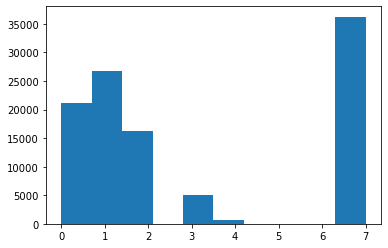

In [267]:
import matplotlib.pyplot as ply
ply.hist(temp_data.专业特长_具体要求_difflibs,bins=10)

In [268]:
pd.cut(temp_data.求职意向岗位类别_具体要求_difflibs, bins=np.arange(0,1,0.1))

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
106060    NaN
106061    NaN
106062    NaN
106063    NaN
106064    NaN
Name: 求职意向岗位类别_具体要求_difflibs, Length: 106065, dtype: category
Categories (9, interval[float64]): [(0.0, 0.1] < (0.1, 0.2] < (0.2, 0.3] < (0.3, 0.4] ... (0.5, 0.6] < (0.6, 0.7] < (0.7, 0.8] < (0.8, 0.9]]

In [269]:
np.arange(0,1,0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [270]:
temp_data[temp_data.求职者编号_岗位编号==37815]["求职意向岗位类别_对应聘者的专业要求_simhash"]

3    2
Name: 求职意向岗位类别_对应聘者的专业要求_simhash, dtype: int32

In [271]:
X_train.shape,Y_train.shape,X_val.shape,Y_val.shape

((28232, 175), (28232, 1), (7059, 175), (7059, 1))

In [272]:
import lightgbm
from sklearn.model_selection import KFold
X = pd.concat([train,valid],ignore_index=True).reset_index(drop=True)
y = pd.concat([train_label,valid_label],ignore_index=True).reset_index(drop=True)
# X =X[X.columns[:112]]
oof = []
df_importance_list = []
# model = lightgbm.LGBMClassifier(num_leaves=64,
#                            max_depth=10,
#                            learning_rate=0.1,
#                            n_estimators=1000000,
#                            subsample=0.8,
#                            feature_fraction=0.8,
#                            reg_alpha=0.5,
#                            reg_lambda=0.5,
#                            random_state=2048,
#                            metric='auc')
kfold = KFold(n_splits=5, random_state=2048, shuffle=True)
for fold_id, (trn_idx, val_idx) in enumerate(kfold.split(X, y)):
    X_train = X.loc[trn_idx]
    Y_train = y.loc[trn_idx]

    X_val = X.loc[val_idx]
    Y_val = y.loc[val_idx]
    train_set = lightgbm.Dataset(X_train.values, label=Y_train)
    val_set = lightgbm.Dataset(X_val.values, label=Y_val)
    
    lgb_model = lightgbm.train(train_set=train_set,
                           valid_sets=[val_set],
                           num_boost_round=3000,
                           params=params,
                           feval=lgb_f1_score,
                           early_stopping_rounds=100)
    print('\nFold_{} Training ================================\n'.format(fold_id + 1))

    pred_val = lgb_model.predict(X_val,num_iteration=lgb_model.best_iteration)
    df_oof = X.iloc[val_idx][['岗位编号', '求职者编号']].copy()
    df_oof['标签'] = y.iloc[val_idx][['标签']].copy()
    df_oof['pred'] = pred_val
    oof.append(df_oof)


    df_importance = pd.DataFrame({
        'column': list(X.columns),
        'importance': lgb_model.feature_importance(),
    })
    df_importance_list.append(df_importance)


[1]	valid_0's binary_logloss: 0.409228	valid_0's f1: 0
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.380433	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.356781	valid_0's f1: 0
[4]	valid_0's binary_logloss: 0.336924	valid_0's f1: 0
[5]	valid_0's binary_logloss: 0.323664	valid_0's f1: 0
[6]	valid_0's binary_logloss: 0.307731	valid_0's f1: 0
[7]	valid_0's binary_logloss: 0.297454	valid_0's f1: 0
[8]	valid_0's binary_logloss: 0.284455	valid_0's f1: 0
[9]	valid_0's binary_logloss: 0.272817	valid_0's f1: 0.00355556
[10]	valid_0's binary_logloss: 0.262254	valid_0's f1: 0.672963
[11]	valid_0's binary_logloss: 0.252679	valid_0's f1: 0.697917
[12]	valid_0's binary_logloss: 0.24387	valid_0's f1: 0.720137
[13]	valid_0's binary_logloss: 0.237612	valid_0's f1: 0.734831
[14]	valid_0's binary_logloss: 0.22997	valid_0's f1: 0.759229
[15]	valid_0's binary_logloss: 0.222885	valid_0's f1: 0.774334
[16]	valid_0's binary_logloss: 0.216347	valid_0's f1: 0.7

[136]	valid_0's binary_logloss: 0.110936	valid_0's f1: 0.860487
[137]	valid_0's binary_logloss: 0.110918	valid_0's f1: 0.86089
[138]	valid_0's binary_logloss: 0.110808	valid_0's f1: 0.861697
[139]	valid_0's binary_logloss: 0.110753	valid_0's f1: 0.861697
[140]	valid_0's binary_logloss: 0.110697	valid_0's f1: 0.860759
[141]	valid_0's binary_logloss: 0.110682	valid_0's f1: 0.861697
[142]	valid_0's binary_logloss: 0.110705	valid_0's f1: 0.861697
[143]	valid_0's binary_logloss: 0.110624	valid_0's f1: 0.861163
[144]	valid_0's binary_logloss: 0.11065	valid_0's f1: 0.860356
[145]	valid_0's binary_logloss: 0.110711	valid_0's f1: 0.860225
[146]	valid_0's binary_logloss: 0.110744	valid_0's f1: 0.861842
[147]	valid_0's binary_logloss: 0.11073	valid_0's f1: 0.861842
[148]	valid_0's binary_logloss: 0.110743	valid_0's f1: 0.861437
[149]	valid_0's binary_logloss: 0.110721	valid_0's f1: 0.861437
[150]	valid_0's binary_logloss: 0.110689	valid_0's f1: 0.861437
[151]	valid_0's binary_logloss: 0.110716	va

[265]	valid_0's binary_logloss: 0.110529	valid_0's f1: 0.863551
[266]	valid_0's binary_logloss: 0.110607	valid_0's f1: 0.863955
[267]	valid_0's binary_logloss: 0.110563	valid_0's f1: 0.863551
[268]	valid_0's binary_logloss: 0.110618	valid_0's f1: 0.863424
[269]	valid_0's binary_logloss: 0.110612	valid_0's f1: 0.864082
[270]	valid_0's binary_logloss: 0.110603	valid_0's f1: 0.864486
[271]	valid_0's binary_logloss: 0.110536	valid_0's f1: 0.863955
[272]	valid_0's binary_logloss: 0.110498	valid_0's f1: 0.863955
[273]	valid_0's binary_logloss: 0.110496	valid_0's f1: 0.86302
[274]	valid_0's binary_logloss: 0.110516	valid_0's f1: 0.863424
[275]	valid_0's binary_logloss: 0.110528	valid_0's f1: 0.86302
[276]	valid_0's binary_logloss: 0.110487	valid_0's f1: 0.863148
[277]	valid_0's binary_logloss: 0.110513	valid_0's f1: 0.863148
[278]	valid_0's binary_logloss: 0.110439	valid_0's f1: 0.863148
[279]	valid_0's binary_logloss: 0.110479	valid_0's f1: 0.863551
[280]	valid_0's binary_logloss: 0.11046	va

[87]	valid_0's binary_logloss: 0.121677	valid_0's f1: 0.855646
[88]	valid_0's binary_logloss: 0.121426	valid_0's f1: 0.855646
[89]	valid_0's binary_logloss: 0.121432	valid_0's f1: 0.855238
[90]	valid_0's binary_logloss: 0.121292	valid_0's f1: 0.855646
[91]	valid_0's binary_logloss: 0.121163	valid_0's f1: 0.856464
[92]	valid_0's binary_logloss: 0.121012	valid_0's f1: 0.85592
[93]	valid_0's binary_logloss: 0.120897	valid_0's f1: 0.856464
[94]	valid_0's binary_logloss: 0.12075	valid_0's f1: 0.857414
[95]	valid_0's binary_logloss: 0.120592	valid_0's f1: 0.857414
[96]	valid_0's binary_logloss: 0.120483	valid_0's f1: 0.857007
[97]	valid_0's binary_logloss: 0.120374	valid_0's f1: 0.85755
[98]	valid_0's binary_logloss: 0.120207	valid_0's f1: 0.85782
[99]	valid_0's binary_logloss: 0.120224	valid_0's f1: 0.857685
[100]	valid_0's binary_logloss: 0.120188	valid_0's f1: 0.857278
[101]	valid_0's binary_logloss: 0.120086	valid_0's f1: 0.857278
[102]	valid_0's binary_logloss: 0.11997	valid_0's f1: 0.8

[222]	valid_0's binary_logloss: 0.119672	valid_0's f1: 0.859962
[223]	valid_0's binary_logloss: 0.119675	valid_0's f1: 0.860498
[224]	valid_0's binary_logloss: 0.119715	valid_0's f1: 0.860498
[225]	valid_0's binary_logloss: 0.119719	valid_0's f1: 0.860498
[226]	valid_0's binary_logloss: 0.119703	valid_0's f1: 0.860094
[227]	valid_0's binary_logloss: 0.119666	valid_0's f1: 0.860094
[228]	valid_0's binary_logloss: 0.119651	valid_0's f1: 0.860094
[229]	valid_0's binary_logloss: 0.119702	valid_0's f1: 0.860498
[230]	valid_0's binary_logloss: 0.119713	valid_0's f1: 0.859426
Early stopping, best iteration is:
[130]	valid_0's binary_logloss: 0.118854	valid_0's f1: 0.859574

Fold_2 Training ================================

[1]	valid_0's binary_logloss: 0.408719	valid_0's f1: 0
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.380204	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.357013	valid_0's f1: 0
[4]	valid_0's binary_logloss: 0.337404	valid_0

[123]	valid_0's binary_logloss: 0.111264	valid_0's f1: 0.863268
[124]	valid_0's binary_logloss: 0.111275	valid_0's f1: 0.863398
[125]	valid_0's binary_logloss: 0.111217	valid_0's f1: 0.86381
[126]	valid_0's binary_logloss: 0.111158	valid_0's f1: 0.863268
[127]	valid_0's binary_logloss: 0.111144	valid_0's f1: 0.863268
[128]	valid_0's binary_logloss: 0.11112	valid_0's f1: 0.863268
[129]	valid_0's binary_logloss: 0.110967	valid_0's f1: 0.863268
[130]	valid_0's binary_logloss: 0.110892	valid_0's f1: 0.86381
[131]	valid_0's binary_logloss: 0.11087	valid_0's f1: 0.863528
[132]	valid_0's binary_logloss: 0.110844	valid_0's f1: 0.862167
[133]	valid_0's binary_logloss: 0.110711	valid_0's f1: 0.862577
[134]	valid_0's binary_logloss: 0.110602	valid_0's f1: 0.862577
[135]	valid_0's binary_logloss: 0.110535	valid_0's f1: 0.862167
[136]	valid_0's binary_logloss: 0.110493	valid_0's f1: 0.862446
[137]	valid_0's binary_logloss: 0.11045	valid_0's f1: 0.861217
[138]	valid_0's binary_logloss: 0.11042	valid

[252]	valid_0's binary_logloss: 0.109161	valid_0's f1: 0.865275
[253]	valid_0's binary_logloss: 0.109146	valid_0's f1: 0.865686
[254]	valid_0's binary_logloss: 0.109115	valid_0's f1: 0.865686
[255]	valid_0's binary_logloss: 0.109039	valid_0's f1: 0.866351
[256]	valid_0's binary_logloss: 0.109013	valid_0's f1: 0.865813
[257]	valid_0's binary_logloss: 0.108988	valid_0's f1: 0.866635
[258]	valid_0's binary_logloss: 0.109023	valid_0's f1: 0.866635
[259]	valid_0's binary_logloss: 0.109066	valid_0's f1: 0.866224
[260]	valid_0's binary_logloss: 0.109027	valid_0's f1: 0.866635
[261]	valid_0's binary_logloss: 0.109011	valid_0's f1: 0.866635
[262]	valid_0's binary_logloss: 0.109001	valid_0's f1: 0.866635
[263]	valid_0's binary_logloss: 0.108985	valid_0's f1: 0.866761
[264]	valid_0's binary_logloss: 0.108952	valid_0's f1: 0.86594
[265]	valid_0's binary_logloss: 0.108954	valid_0's f1: 0.866761
[266]	valid_0's binary_logloss: 0.108929	valid_0's f1: 0.86594
[267]	valid_0's binary_logloss: 0.108894	v

[53]	valid_0's binary_logloss: 0.125663	valid_0's f1: 0.855899
[54]	valid_0's binary_logloss: 0.124865	valid_0's f1: 0.857419
[55]	valid_0's binary_logloss: 0.124253	valid_0's f1: 0.859352
[56]	valid_0's binary_logloss: 0.12353	valid_0's f1: 0.858522
[57]	valid_0's binary_logloss: 0.12291	valid_0's f1: 0.860723
[58]	valid_0's binary_logloss: 0.122244	valid_0's f1: 0.860857
[59]	valid_0's binary_logloss: 0.121725	valid_0's f1: 0.861405
[60]	valid_0's binary_logloss: 0.121097	valid_0's f1: 0.861953
[61]	valid_0's binary_logloss: 0.120599	valid_0's f1: 0.861124
[62]	valid_0's binary_logloss: 0.120122	valid_0's f1: 0.860711
[63]	valid_0's binary_logloss: 0.119643	valid_0's f1: 0.860845
[64]	valid_0's binary_logloss: 0.119125	valid_0's f1: 0.860845
[65]	valid_0's binary_logloss: 0.118657	valid_0's f1: 0.860845
[66]	valid_0's binary_logloss: 0.118266	valid_0's f1: 0.860845
[67]	valid_0's binary_logloss: 0.117798	valid_0's f1: 0.861111
[68]	valid_0's binary_logloss: 0.117356	valid_0's f1: 0.8

[185]	valid_0's binary_logloss: 0.108583	valid_0's f1: 0.865658
[186]	valid_0's binary_logloss: 0.108605	valid_0's f1: 0.865658
[187]	valid_0's binary_logloss: 0.108655	valid_0's f1: 0.867139
[188]	valid_0's binary_logloss: 0.108565	valid_0's f1: 0.866194
[189]	valid_0's binary_logloss: 0.108542	valid_0's f1: 0.866194
[190]	valid_0's binary_logloss: 0.108532	valid_0's f1: 0.86673
[191]	valid_0's binary_logloss: 0.108514	valid_0's f1: 0.867265
[192]	valid_0's binary_logloss: 0.108537	valid_0's f1: 0.866856
[193]	valid_0's binary_logloss: 0.108559	valid_0's f1: 0.86673
[194]	valid_0's binary_logloss: 0.10855	valid_0's f1: 0.86673
[195]	valid_0's binary_logloss: 0.108579	valid_0's f1: 0.86755
[196]	valid_0's binary_logloss: 0.10861	valid_0's f1: 0.867139
[197]	valid_0's binary_logloss: 0.108659	valid_0's f1: 0.866604
[198]	valid_0's binary_logloss: 0.108662	valid_0's f1: 0.866194
[199]	valid_0's binary_logloss: 0.10875	valid_0's f1: 0.866604
[200]	valid_0's binary_logloss: 0.108709	valid_

[40]	valid_0's binary_logloss: 0.143975	valid_0's f1: 0.845658
[41]	valid_0's binary_logloss: 0.142638	valid_0's f1: 0.845238
[42]	valid_0's binary_logloss: 0.141625	valid_0's f1: 0.842992
[43]	valid_0's binary_logloss: 0.140586	valid_0's f1: 0.843409
[44]	valid_0's binary_logloss: 0.139379	valid_0's f1: 0.846116
[45]	valid_0's binary_logloss: 0.138275	valid_0's f1: 0.846154
[46]	valid_0's binary_logloss: 0.137298	valid_0's f1: 0.846723
[47]	valid_0's binary_logloss: 0.136251	valid_0's f1: 0.847291
[48]	valid_0's binary_logloss: 0.135161	valid_0's f1: 0.847441
[49]	valid_0's binary_logloss: 0.134222	valid_0's f1: 0.847591
[50]	valid_0's binary_logloss: 0.133294	valid_0's f1: 0.84902
[51]	valid_0's binary_logloss: 0.132435	valid_0's f1: 0.851272
[52]	valid_0's binary_logloss: 0.131766	valid_0's f1: 0.851834
[53]	valid_0's binary_logloss: 0.130888	valid_0's f1: 0.854634
[54]	valid_0's binary_logloss: 0.130167	valid_0's f1: 0.853659
[55]	valid_0's binary_logloss: 0.129476	valid_0's f1: 0.

[300]	valid_0's binary_logloss: 0.114076	valid_0's f1: 0.868246
[301]	valid_0's binary_logloss: 0.114041	valid_0's f1: 0.868371
[302]	valid_0's binary_logloss: 0.114068	valid_0's f1: 0.867835
[303]	valid_0's binary_logloss: 0.114041	valid_0's f1: 0.867173
[304]	valid_0's binary_logloss: 0.114052	valid_0's f1: 0.866888
[305]	valid_0's binary_logloss: 0.114069	valid_0's f1: 0.866761
[306]	valid_0's binary_logloss: 0.114073	valid_0's f1: 0.866761
Early stopping, best iteration is:
[206]	valid_0's binary_logloss: 0.112095	valid_0's f1: 0.868121

Fold_5 Training ================================



In [273]:
X_val

,岗位编号,求职者编号,性别,工作年限,最高学历,应聘者专业,年龄,最近工作岗位,最近所在行业,当前工作所在地,...,专业特长_具体要求_difflibs,求职意向岗位类别_招聘职位_difflibs,求职意向岗位类别_对应聘者的专业要求_difflibs,求职意向岗位类别_具体要求_difflibs,求职意向所在行业_招聘职位_difflibs,求职意向所在行业_对应聘者的专业要求_difflibs,求职意向所在行业_具体要求_difflibs,自荐信_招聘职位_difflibs,自荐信_对应聘者的专业要求_difflibs,自荐信_具体要求_difflibs
1,799873,6139430,1,12,4.0,216,37,119,116,43,...,0,1,1,0,8,6,4,0,0,2
2,779698,6083324,1,0,1.0,276,31,255,0,43,...,7,2,1,0,8,6,4,6,5,1
3,771109,5873085,0,6,4.0,373,33,242,0,43,...,7,4,8,0,8,6,4,0,5,4
7,779698,6174300,1,0,2.0,237,28,260,35,0,...,7,9,8,0,8,6,4,6,5,1
9,772901,5879364,0,0,2.0,80,28,217,0,43,...,7,9,8,0,8,6,0,6,5,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35244,774781,6055021,1,8,3.0,34,28,242,0,43,...,0,9,8,1,8,6,4,6,5,1
35263,774773,2856929,0,15,4.0,327,37,276,21,43,...,1,7,8,7,8,6,4,0,5,2
35264,513553,6262246,1,20,1.0,64,39,14,0,43,...,7,7,8,7,3,6,0,6,5,7
35273,838002,6265550,1,14,1.0,291,35,140,0,43,...,0,9,8,7,8,6,4,6,5,7


In [390]:
df_importance.to_csv('result.csv')

In [405]:
len(lgb_model.feature_importance()),len(list(test0.columns)[:2]+list(test0.columns)[3:])

(112, 176)

In [313]:
from sklearn.metrics import roc_auc_score
df_oof = pd.concat(oof)
df_oof.sort_values(['pred'], inplace=True, ascending=False)
df_oof.reset_index(drop=True, inplace=True)
df_oof['pred_label'] = 0
df_oof.loc[:int(0.14 * len(df_oof)), 'pred_label'] = 1
df_oof["pred_label_class"] =df_oof.pred.apply(lambda x:round(x) )
f1 = f1_score(df_oof["标签"], df_oof['pred_label'])
auc = roc_auc_score(df_oof["标签"], df_oof['pred_label'])
f1, auc

(0.8640409013444423, 0.899518561137465)

In [501]:
round(0.51)

1

In [496]:
df_oof[]

,岗位编号,求职者编号,标签,pred,pred_label
0,43922680,316802963,1,0.999971,1
1,43267862,317749941,1,0.999951,1
2,43922680,320945910,1,0.999947,1
3,44172666,321029922,1,0.999946,1
4,43524687,319520903,1,0.999943,1
...,...,...,...,...,...
35286,786572,5749793,0,0.000181,0
35287,813149,6261287,0,0.000181,0
35288,766805,6185851,0,0.000154,0
35289,820414,6258854,0,0.000149,0


In [327]:
df_importance = pd.concat(df_importance_list)
df_importance = df_importance.groupby([
    'column'
])['importance'].agg('mean')#.sort_values(ascending=False).reset_index()
df_importance.to_csv(r'result_import_177.csv')

In [185]:
# 112维特征：0.8642 : 0.900 ；0.8702
# 175维特征：0.8649  ： 0.901:

## online

In [78]:
train_data.head()

,岗位编号,求职者编号,标签
0,775040,5969825,0
1,815337,6212884,0
2,770107,5451198,0
3,43795661,320873919,1
4,798922,5650936,0


In [305]:
# online
data=pd.concat([train_data,valid_data],ignore_index=True)
train_online=get_k_fold_data(data,person,intent_table,job_table,project_history_table,work_history_table,candidate_data,job_data)
test_data0 =data_merge(test_data,person,intent_table,job_table,project_history_table,work_history_table,candidate_data,job_data)
test_online = get_data(test_data0, train_online)

In [306]:
train_online["求职者编号_岗位编号"]=train_online["求职者编号"].astype("str")+train_online["岗位编号"].astype("str")
test_online["求职者编号_岗位编号"]=test_online["求职者编号"].astype("str")+test_online["岗位编号"].astype("str")
temp_data_online["求职者编号_岗位编号"]=temp_data_online["求职者编号"].astype("str")+temp_data_online["岗位编号"].astype("str")

In [307]:
# 获取投递记录相关指标的统计值
temp_data_online= pd.concat([train_online, test_online], ignore_index=True)
# data_all_feature=feature_process(temp_data)
temp_data_online=deliver_record_feature(temp_data_online)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.55s/it]


In [308]:
temp_data_online = temp_data_online[["岗位编号", "求职者编号", "标签","求职者编号_岗位编号"] + [column for column in temp_data_online.columns if
                                                   column not in ["岗位编号", "求职者编号", "标签","求职者编号_岗位编号"]]]
temp_data_online = pd.merge(temp_data_online,data_all_tmp[data_all_tmp.columns[-64:]].drop_duplicates(),on='求职者编号_岗位编号')

In [309]:
temp_data_online.head()

,岗位编号,求职者编号,标签,求职者编号_岗位编号,性别,工作年限,最高学历,应聘者专业,年龄,最近工作岗位,...,专业特长_具体要求_difflibs,求职意向岗位类别_招聘职位_difflibs,求职意向岗位类别_对应聘者的专业要求_difflibs,求职意向岗位类别_具体要求_difflibs,求职意向所在行业_招聘职位_difflibs,求职意向所在行业_对应聘者的专业要求_difflibs,求职意向所在行业_具体要求_difflibs,自荐信_招聘职位_difflibs,自荐信_对应聘者的专业要求_difflibs,自荐信_具体要求_difflibs
0,775040,5969825,0,5969825775040,1,12,3.0,None,34,品质/质检,...,1,9,8,1,8,6,4,6,5,1
1,799873,6139430,0,6139430799873,1,12,4.0,机电一体化,37,机械设计,...,7,9,8,0,8,6,4,0,5,1
2,779698,6083324,0,6083324779698,1,0,1.0,特殊教育学,31,仓储管理,...,7,9,8,7,8,6,4,6,5,1
3,771109,5873085,0,5873085771109,0,6,4.0,财务管理,33,NaN,...,2,4,3,0,8,6,0,0,0,2
4,823833,6218282,0,6218282823833,0,0,3.0,英语,29,客户服务,...,7,9,4,0,8,6,4,0,0,2


In [310]:
temp_data_online[temp_data_online.求职者编号_岗位编号==37815]["求职意向岗位类别_对应聘者的专业要求_simhash"]

Series([], Name: 求职意向岗位类别_对应聘者的专业要求_simhash, dtype: int32)

In [311]:
for f in temp_data_online.select_dtypes('object'):
    le = LabelEncoder()
    print(f)
    temp_data_online[f] = le.fit_transform(temp_data_online[f].astype('str'))
temp_data_online["招聘对象"] =le.fit_transform(temp_data_online["招聘对象"].astype('str'))
temp_data_online["最近工作岗位"] =le.fit_transform(temp_data_online["最近工作岗位"].astype('str'))
temp_data_online["求职意向岗位类别"] =le.fit_transform(temp_data_online["求职意向岗位类别"].astype('str'))





求职者编号_岗位编号
应聘者专业
最近工作岗位
最近所在行业
当前工作所在地
语言能力
专业特长
招聘职位
对应聘者的专业要求
岗位工作地点
具体要求
自荐信
求职意向工作地点
求职意向所在行业
其他说明
汉语语言能力
英语语言能力
粤语语言能力
日语语言能力


In [315]:
temp_data_online.head()

,岗位编号,求职者编号,标签,求职者编号_岗位编号,性别,工作年限,最高学历,应聘者专业,年龄,最近工作岗位,...,专业特长_具体要求_difflibs,求职意向岗位类别_招聘职位_difflibs,求职意向岗位类别_对应聘者的专业要求_difflibs,求职意向岗位类别_具体要求_difflibs,求职意向所在行业_招聘职位_difflibs,求职意向所在行业_对应聘者的专业要求_difflibs,求职意向所在行业_具体要求_difflibs,自荐信_招聘职位_difflibs,自荐信_对应聘者的专业要求_difflibs,自荐信_具体要求_difflibs
0,775040,5969825,0,43073,1,12,3.0,0,34,281,...,1,9,8,1,8,6,4,6,5,1
1,799873,6139430,0,75369,1,12,4.0,216,37,86,...,7,9,8,0,8,6,4,0,5,1
2,779698,6083324,0,64742,1,0,1.0,276,31,235,...,7,9,8,7,8,6,4,6,5,1
3,771109,5873085,0,37815,0,6,4.0,373,33,226,...,2,4,3,0,8,6,0,0,0,2
4,823833,6218282,0,88752,0,0,3.0,349,29,12,...,7,9,4,0,8,6,4,0,0,2


In [336]:
data_all_feature_online.to_csv(r'feature_online_175.csv')

In [314]:
train.shape,valid.shape,test.shape,train_online.shape,test_online.shape

((28232, 175), (7059, 175), (70774, 57), (35291, 58), (70774, 58))

In [316]:
data_all_feature_online  =temp_data_online
#train,train_label,valid,valid_label
train0 = data_all_feature_online[:train_online.shape[0]]#.标签.value_counts()
test_online = data_all_feature_online[train_online.shape[0]:]
train_label_online = train0["标签"]
train_online=train0[list(train0.columns)[:2]+list(train0.columns)[4:]]
test_online=test_online[list(test_online.columns)[:2]+list(test_online.columns)[4:]]

In [317]:
train_online.shape,test_online.shape

((35291, 175), (70774, 175))

In [322]:
import lightgbm
model = lightgbm.train(train_set=lightgbm.Dataset(train_online.values, train_label_online.values),
                       num_boost_round=1000,
                       params=params)



In [323]:
train_online.values

array([[775040, 5969825, 1, ..., 6, 5, 1],
       [799873, 6139430, 1, ..., 0, 5, 1],
       [779698, 6083324, 1, ..., 6, 5, 1],
       ...,
       [775836, 6045150, 0, ..., 0, 5, 0],
       [839452, 5591966, 0, ..., 0, 5, 2],
       [815819, 5887783, 1, ..., 6, 5, 7]], dtype=object)

In [325]:
# from utils import submission
    
path2=path0+'/result/'
name ='online_175_feature_1000'
test_online["预测打分"] = model.predict(test_online.values)
test_online["预测类别"] =test_online["预测打分"].apply(lambda x:round(x) )
test_online = test_online.sort_values("预测打分", ascending=False, ignore_index=True)
test_online["预测"] = 0
test_online.loc[:int(0.15 * len(test_online)), ["预测"]] = 1

submit = test_online[["岗位编号", "求职者编号", "预测"]]
submit.columns = ["RECRUIT_ID", "PERSON_ID", "LABEL"]
submit.to_csv(path2 + name + ".csv", index=False)
del test_online["预测打分"]
del test_online["预测类别"]
del test_online["预测"]

In [108]:
test_online#[(test_data.岗位编号==42732392)&(test_data.求职者编号==4918222)]

,岗位编号,求职者编号,性别,工作年限,最高学历,应聘者专业,年龄,最近工作岗位,最近所在行业,当前工作所在地,...,岗位编号_可到职天数_max,岗位编号_可到职天数_min,岗位编号_可到职天数_std,岗位编号_可到职天数_median,岗位编号_可到职天数_mode,岗位编号_可到职天数_mode_rate,岗位编号_性别_mode,岗位编号_性别_mode_rate,岗位编号_工作地点符合否_mode,岗位编号_工作地点符合否_mode_rate
0,44172666,321298925,0,5,4.0,349,29,288,80,43,...,180.0,7.0,36.052991,7.0,7.0,0.822222,0,0.869565,1.0,0.847826
1,42907680,316480900,0,5,3.0,0,28,174,82,19,...,14.0,7.0,1.527525,7.0,7.0,0.952381,0,0.857143,0.0,1.000000
2,43621663,320934905,0,7,3.0,329,5,288,80,43,...,180.0,7.0,26.428022,7.0,7.0,0.790909,1,0.636364,1.0,0.859091
3,42372664,316479909,1,6,3.0,318,28,288,80,56,...,30.0,7.0,3.946830,7.0,7.0,0.944444,1,0.960000,1.0,0.800000
4,43795661,316450912,0,9,3.0,59,33,196,55,70,...,180.0,7.0,19.234797,7.0,7.0,0.782123,0,0.989071,1.0,0.868852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70769,772337,6015851,1,0,4.0,364,30,226,0,43,...,30.0,7.0,3.252691,7.0,7.0,0.980000,1,0.960000,0.0,1.000000
70770,821777,6257090,1,0,4.0,145,30,226,0,2,...,30.0,7.0,7.628237,7.0,7.0,0.880000,1,0.920000,0.0,0.960000
70771,772338,5985485,1,8,4.0,149,31,15,0,19,...,30.0,7.0,4.130922,7.0,7.0,0.967742,0,0.727273,0.0,0.969697
70772,770533,6125754,1,7,4.0,145,31,226,0,0,...,180.0,7.0,21.781560,7.0,7.0,0.764706,1,0.929577,0.0,0.985915


In [109]:
submit

,RECRUIT_ID,PERSON_ID,LABEL
0,44172666,321298925,1
1,42907680,316480900,1
2,43621663,320934905,1
3,42372664,316479909,1
4,43795661,316450912,1
...,...,...,...
70769,772337,6015851,0
70770,821777,6257090,0
70771,772338,5985485,0
70772,770533,6125754,0


* one-hot +岗位编号	求职者编号 0.8633      ONLINE:0.8653
* no one hot +岗位编号	求职者编号 0.865602      ONLINE:0.8663
* 添加招聘岗位投递记录中的求职意向岗位，求职者专业，（年龄、工作经历数、项目经验数、可到职天数）统计指标、工作地点符合占比特征
* 0.8665 online：0.86748
* 添加k-折交叉的标签特征：offline:0.8772  online: 0.8711
* 112维特征：0.869288

In [2]:
import pandas as pd
df1 = pd.DataFrame([1,2,3,4,5,6])

In [5]:
df1[1]=[1,1,1,1,2,2]

In [6]:
df1

,0,1
0,1,1
1,2,1
2,3,1
3,4,1
4,5,2
5,6,2


In [7]:
f1=1
f2=0
df1.groupby(f1)[f2].agg(
        [(f"{f1}_{f2}_mean", "mean"),
         (f"{f1}_{f2}_max", "max"),
         (f"{f1}_{f2}_min", "min"),
         (f"{f1}_{f2}_std", "std")]
    ).reset_index()

,1,1_0_mean,1_0_max,1_0_min,1_0_std
0,1,2.5,4,1,1.290994
1,2,5.5,6,5,0.707107
